# Playing with Pytorch Geometric

In [2]:
import torch
from torch_geometric.data import Data
import networkx as nx # for visualizing graphs
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

# Define two (bidirectional) edges: between nodes [0,1] and between nodes [1,2]:
edge_index = torch.tensor([[0, 1, 1, 2], 
                           [1, 0, 2, 1]], dtype=torch.long)

# Define node features 
x = torch.tensor([[-1], # node 0
                  [0],  # node 1
                  [1]], # node 2
                 dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

Visualize it:

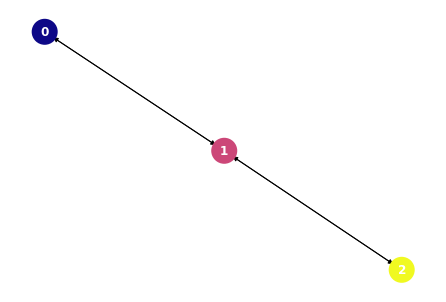

In [3]:
plt.figure() 
nx.draw(to_networkx(data), 
        cmap='plasma', 
        node_color = np.arange(data.num_nodes),
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [4]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

Graph nodes have 1 node feature(s) each.
Graph has 3 nodes and 4 edges.
Is the graph undirected?: True


## Load the Cora dataset (a single graph) & visualize it

In [19]:
cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
cora = cora_dataset[0] # grab the graph itself, i.e. the "first entry"
coragraph = to_networkx(cora)
node_labels = cora.y[list(coragraph.nodes)].numpy()

Processing...
Done!


In [20]:
print("Dataset has {} entries, with {} classes and {} node features.".format(len(cora_dataset), cora_dataset.num_classes, cora_dataset.num_node_features))
print("Graph has {:,} nodes and {:,} edges.".format(cora.num_nodes, cora.num_edges))
print("Is the graph undirected?: {}".format(cora.is_undirected()))

Dataset has 1 entries, with 7 classes and 1433 node features.
Graph has 2,708 nodes and 10,556 edges.
Is the graph undirected?: True


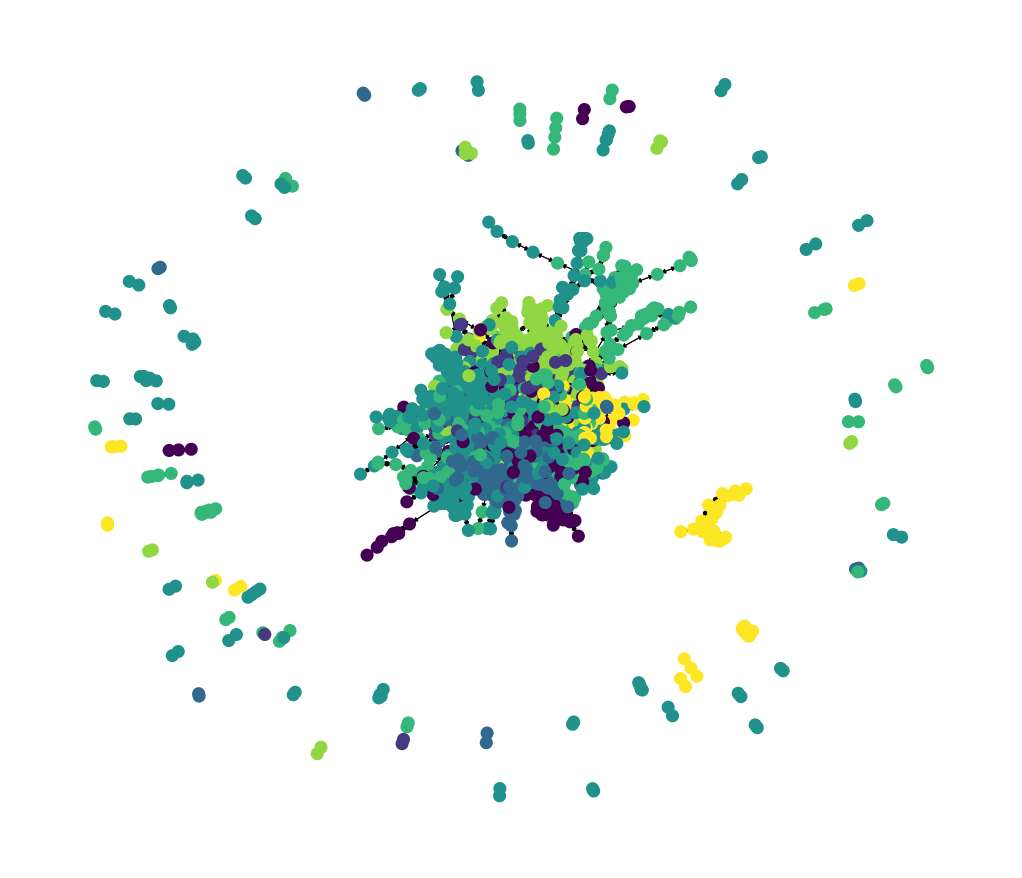

In [21]:
plt.figure(figsize=(14,12)) 
nx.draw(coragraph, cmap='viridis', node_color = node_labels, node_size=50, linewidths=6)

Define a 2-layer graph convolutional network to train on Cora:

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class MyGCN(torch.nn.Module):
    def __init__(self):
        super(MyGCN, self).__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyGCN().to(device)
data = cora_dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

Now train... (note that `train_mask` is built into the dataset)

In [24]:
losses = []
model.train()
for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

100%|██████████| 200/200 [00:06<00:00, 29.19it/s]


Text(0, 0.5, 'Loss')

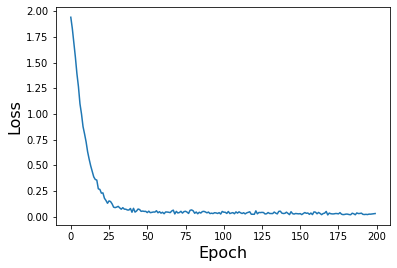

In [25]:
plt.plot(np.arange(200),losses)
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)

Evaluate performance on a test set:

In [26]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7980


## Load the ENZYMES dataset & visualize it

In [ ]:
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

In [ ]:
print("Dataset has {} entries, with {} classes and {} node features.".format(len(enzymes), enzymes.num_classes, enzymes.num_node_features))
print("First entry has {:,} nodes and {:,} edges.".format(enzymes[0].num_nodes, enzymes[0].num_edges))
print("Is the graph undirected?: {}".format(enzymes[0].is_undirected()))

In [ ]:
plt.figure() 
graph = enzymes[0]
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

# Load my mocap data

In [5]:
from functions.pytorch_functions import *
from tqdm import tqdm

In [6]:
ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = load_data()

Full data shape: (38309, 53, 3)


In [7]:
seq_len = 128
# index_start = 11910
index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all[index_start:index_start+seq_len]
animation = animate_stick(xtest, 
                          figsize=(10,8), 
                          cmap='inferno', 
                          cloud=False
                         )
HTML(animation.to_html5_video())

Seeding with frame 35373


Get a single frame...

In [8]:
pose = ds_all[index_start]
pose.shape

(53, 3)

Draw skeleton lines as bidirectional edges:

In [9]:
point_labels=['ARIEL','C7','CLAV','LANK','LBHD','LBSH','LBWT','LELB','LFHD','LFRM','LFSH','LFWT','LHEL','LIEL','LIHAND','LIWR','LKNE','LKNI','LMT1','LMT5','LOHAND','LOWR','LSHN','LTHI','LTOE','LUPA','MBWT','MFWT','RANK','RBHD','RBSH','RBWT','RELB','RFHD','RFRM','RFSH','RFWT','RHEL','RIEL','RIHAND','RIWR','RKNE','RKNI','RMT1','RMT5','ROHAND','ROWR','RSHN','RTHI','RTOE','RUPA','STRN','T10']

skeleton_lines = [
#     ( (start group), (end group) ),
    (('LHEL',), ('LTOE',)), # toe to heel
    (('RHEL',), ('RTOE',)),
    (('LMT1',), ('LMT5',)), # horizontal line across foot
    (('RMT1',), ('RMT5',)),   
    (('LHEL',), ('LMT1',)), # heel to sides of feet
    (('LHEL',), ('LMT5',)),
    (('RHEL',), ('RMT1',)),
    (('RHEL',), ('RMT5',)),
    (('LTOE',), ('LMT1',)), # toe to sides of feet
    (('LTOE',), ('LMT5',)),
    (('RTOE',), ('RMT1',)),
    (('RTOE',), ('RMT5',)),
    (('LKNE',), ('LHEL',)), # heel to knee
    (('RKNE',), ('RHEL',)),
    (('LFWT',), ('RBWT',)), # connect pelvis
    (('RFWT',), ('LBWT',)), 
    (('LFWT',), ('RFWT',)), 
    (('LBWT',), ('RBWT',)),
    (('LFWT',), ('LBWT',)), 
    (('RFWT',), ('RBWT',)), 
    (('LFWT',), ('LTHI',)), # pelvis to thighs
    (('RFWT',), ('RTHI',)), 
    (('LBWT',), ('LTHI',)), 
    (('RBWT',), ('RTHI',)), 
    (('LKNE',), ('LTHI',)), 
    (('RKNE',), ('RTHI',)), 
    (('CLAV',), ('LFSH',)), # clavicle to shoulders
    (('CLAV',), ('RFSH',)), 
    (('STRN',), ('LFSH',)), # sternum & T10 (back sternum) to shoulders
    (('STRN',), ('RFSH',)), 
    (('T10',), ('LFSH',)), 
    (('T10',), ('RFSH',)), 
    (('C7',), ('LBSH',)), # back clavicle to back shoulders
    (('C7',), ('RBSH',)), 
    (('LFSH',), ('LBSH',)), # front shoulders to back shoulders
    (('RFSH',), ('RBSH',)), 
    (('LFSH',), ('RBSH',)),
    (('RFSH',), ('LBSH',)),
    (('LFSH',), ('LUPA',),), # shoulders to upper arms
    (('RFSH',), ('RUPA',),), 
    (('LBSH',), ('LUPA',),), 
    (('RBSH',), ('RUPA',),), 
    (('LIWR',), ('LIHAND',),), # wrist to hand
    (('RIWR',), ('RIHAND',),),
    (('LOWR',), ('LOHAND',),), 
    (('ROWR',), ('ROHAND',),),
    (('LIWR',), ('LOWR',),), # across the wrist 
    (('RIWR',), ('ROWR',),), 
    (('LIHAND',), ('LOHAND',),), # across the palm 
    (('RIHAND',), ('ROHAND',),), 
    (('LFHD',), ('LBHD',)), # draw lines around circumference of the head
    (('LBHD',), ('RBHD',)),
    (('RBHD',), ('RFHD',)),
    (('RFHD',), ('LFHD',)),
    (('LFHD',), ('ARIEL',)), # connect circumference points to top of head
    (('LBHD',), ('ARIEL',)),
    (('RBHD',), ('ARIEL',)),
    (('RFHD',), ('ARIEL',)),
]

skeleton_idxs = []
for g1,g2 in skeleton_lines:
    entry = []
    entry.append([point_labels.index(l) for l in g1][0])
    entry.append([point_labels.index(l) for l in g2][0])
    skeleton_idxs.append(entry)

In [10]:
skeleton_idxs

[[12, 24],
 [37, 49],
 [18, 19],
 [43, 44],
 [12, 18],
 [12, 19],
 [37, 43],
 [37, 44],
 [24, 18],
 [24, 19],
 [49, 43],
 [49, 44],
 [16, 12],
 [41, 37],
 [11, 31],
 [36, 6],
 [11, 36],
 [6, 31],
 [11, 6],
 [36, 31],
 [11, 23],
 [36, 48],
 [6, 23],
 [31, 48],
 [16, 23],
 [41, 48],
 [2, 10],
 [2, 35],
 [51, 10],
 [51, 35],
 [52, 10],
 [52, 35],
 [1, 5],
 [1, 30],
 [10, 5],
 [35, 30],
 [10, 30],
 [35, 5],
 [10, 25],
 [35, 50],
 [5, 25],
 [30, 50],
 [15, 14],
 [40, 39],
 [21, 20],
 [46, 45],
 [15, 21],
 [40, 46],
 [14, 20],
 [39, 45],
 [8, 4],
 [4, 29],
 [29, 33],
 [33, 8],
 [8, 0],
 [4, 0],
 [29, 0],
 [33, 0]]

In [11]:
edges = []
edges.append(skeleton_idxs[0][0])
edges.append(skeleton_idxs[0][1])
for i in range(1,len(skeleton_idxs)):
    edges.append(skeleton_idxs[i-1][1])
    edges.append(skeleton_idxs[i][0])
    edges.append(skeleton_idxs[i][1])
print(edges)

[12, 24, 24, 37, 49, 49, 18, 19, 19, 43, 44, 44, 12, 18, 18, 12, 19, 19, 37, 43, 43, 37, 44, 44, 24, 18, 18, 24, 19, 19, 49, 43, 43, 49, 44, 44, 16, 12, 12, 41, 37, 37, 11, 31, 31, 36, 6, 6, 11, 36, 36, 6, 31, 31, 11, 6, 6, 36, 31, 31, 11, 23, 23, 36, 48, 48, 6, 23, 23, 31, 48, 48, 16, 23, 23, 41, 48, 48, 2, 10, 10, 2, 35, 35, 51, 10, 10, 51, 35, 35, 52, 10, 10, 52, 35, 35, 1, 5, 5, 1, 30, 30, 10, 5, 5, 35, 30, 30, 10, 30, 30, 35, 5, 5, 10, 25, 25, 35, 50, 50, 5, 25, 25, 30, 50, 50, 15, 14, 14, 40, 39, 39, 21, 20, 20, 46, 45, 45, 15, 21, 21, 40, 46, 46, 14, 20, 20, 39, 45, 45, 8, 4, 4, 4, 29, 29, 29, 33, 33, 33, 8, 8, 8, 0, 0, 4, 0, 0, 29, 0, 0, 33, 0]


Also define fully-connected edges:

In [12]:
all_edges = []
all_edges_reversed = []
for i in range(pose.shape[0]):
    for j in range(pose.shape[0]):
        all_edges.append(i)
        all_edges.append(j)
        all_edges_reversed.append(j)
        all_edges_reversed.append(i)

### Specific skeleton lines as edges:

In [13]:
# Define node features
x = torch.tensor(pose, dtype=torch.float)

# Define (bidirectional) edges: 
edge_index = torch.tensor([edges,edges[::-1]], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

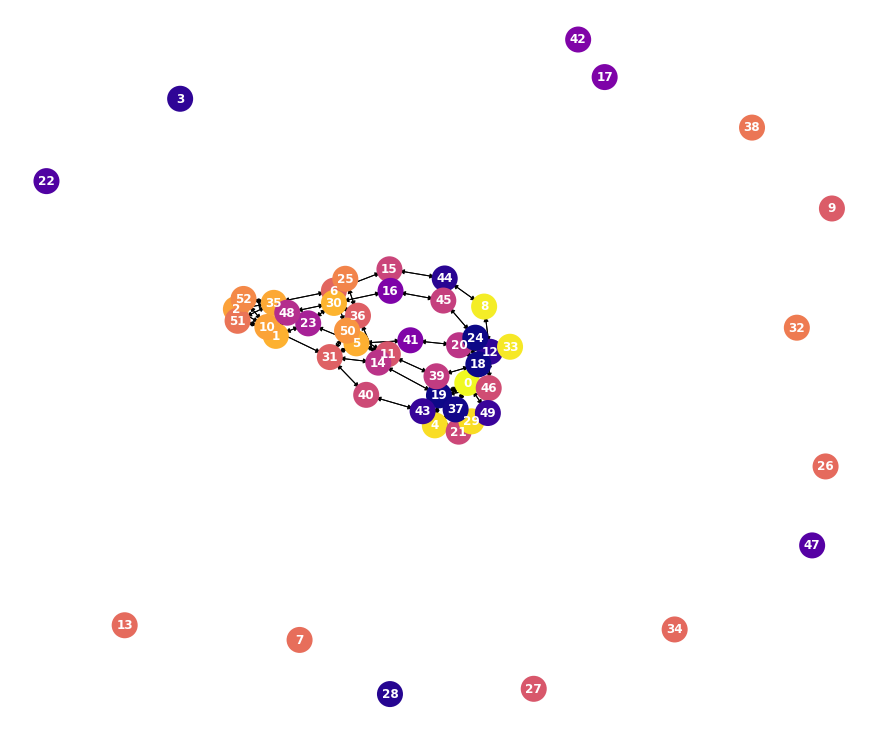

In [14]:
plt.figure(figsize=(12,10)) 
nx.draw(to_networkx(data), 
        cmap='plasma',  # blue is low, yellow is high
#         node_color = np.arange(data.num_nodes), # sequential order
        node_color = x[:,2], # z-coordinate of each point
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [15]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

Graph nodes have 3 node feature(s) each.
Graph has 53 nodes and 173 edges.
Is the graph undirected?: True


### Fully-connected graph:

In [16]:
# Define node features
x = torch.tensor(pose, dtype=torch.float)

# Define (bidirectional) edges: 
edge_index = torch.tensor([all_edges, all_edges_reversed], dtype=torch.long)

data = Data(x=x, edge_index=edge_index)

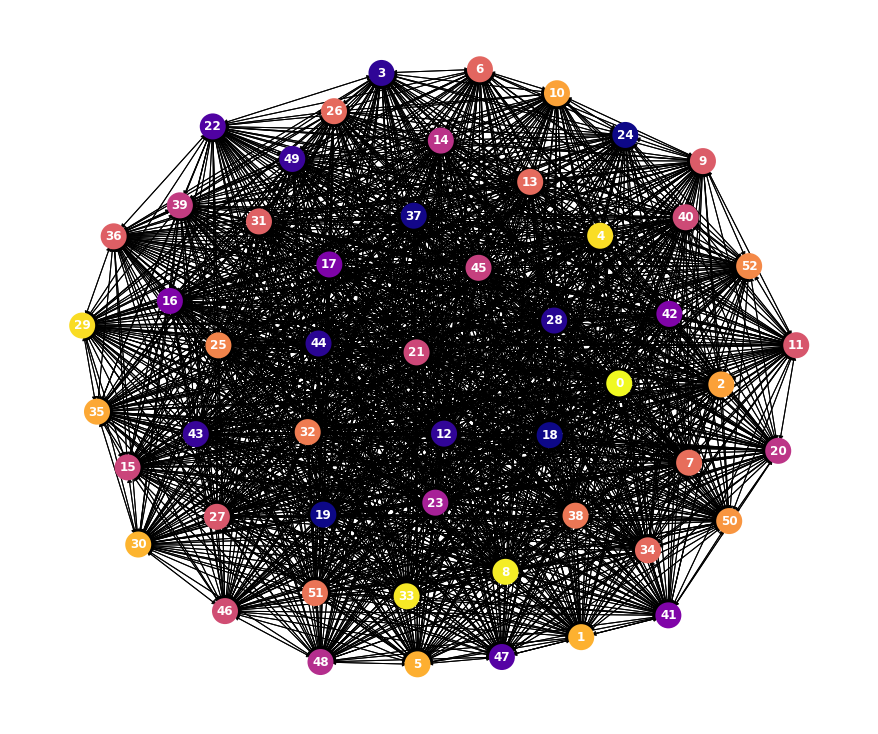

In [17]:
plt.figure(figsize=(12,10)) 
nx.draw(to_networkx(data), 
        cmap='plasma',  # blue is low, yellow is high
#         node_color = np.arange(data.num_nodes), # sequential order
        node_color = x[:,2], # z-coordinate of each point
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [18]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

Graph nodes have 3 node feature(s) each.
Graph has 53 nodes and 5618 edges.
Is the graph undirected?: True
